In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Simple ablation model for testing
class StanceNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.out = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [3]:
# Load newest cleaned CSV (same convention as plots.ipynb)
nb_dir = Path.cwd()  # expected: tests/single_shot_tests
csv_dir = nb_dir / "data" / "stance_converted"
candidates = sorted(csv_dir.glob("cleaned_pairs_*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
if not candidates:
    raise FileNotFoundError(f"No cleaned_pairs_*.csv found in {csv_dir}")
file_path = str(candidates[2])
print("Using:", file_path)
df = pd.read_csv(file_path)

Using: /home/sammli/llm-network/tests/single_shot_tests/data/stance_converted/cleaned_pairs_20260206-020727.csv


In [4]:
# Pick semantic similarity column
preferred_semantic = "in_out_similarity_openai" if "in_out_similarity_openai" in df.columns else None
fallback_semantic = "in_out_similarity_sbert" if "in_out_similarity_sbert" in df.columns else None
semantic_col = preferred_semantic or fallback_semantic
if semantic_col is None:
    raise KeyError("Expected in_out_similarity_openai or in_out_similarity_sbert in CSV")
if preferred_semantic and df[preferred_semantic].isna().all() and fallback_semantic:
    semantic_col = fallback_semantic
print("Semantic similarity column:", semantic_col)

# Ensure numeric types
numeric_cols = [
    "stance_weight",
    "input_stance_score",
    "output_stance_score",
    "output_topic_similarity",
    "output_strength",
    semantic_col,
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Targets
cal_target_col = "input_stance_score"  # embedder-derived initial opinion
if cal_target_col not in df.columns:
    raise KeyError(f"Expected {cal_target_col} in CSV")

# Required inputs for this ablation notebook
required_for_any = [cal_target_col, "output_stance_score", semantic_col]
df = df.dropna(subset=required_for_any).copy()
print("Rows after dropna(required):", len(df))

# Feature sets for ablation (kept intentionally small)
feature_sets = {
    "stance_only": ["output_stance_score"],
    "sim_only": [semantic_col],
    "sim_plus_stance": [semantic_col, "output_stance_score"],
}
extra_out_cols = [c for c in ["output_topic_similarity", "output_strength"] if c in df.columns and (not df[c].isna().all())]
if extra_out_cols:
    feature_sets["sim_plus_stance_plus_outputs"] = [semantic_col, "output_stance_score", *extra_out_cols]
print("Ablations:")
for k, v in feature_sets.items():
    print(" -", k, ":", v)

Semantic similarity column: in_out_similarity_openai
Rows after dropna(required): 300
Ablations:
 - stance_only : ['output_stance_score']
 - sim_only : ['in_out_similarity_openai']
 - sim_plus_stance : ['in_out_similarity_openai', 'output_stance_score']
 - sim_plus_stance_plus_outputs : ['in_out_similarity_openai', 'output_stance_score', 'output_topic_similarity', 'output_strength']


In [5]:
# Train/test split (same split for all ablations)
idx = np.arange(len(df))
idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=0)
train_mask = np.zeros(len(df), dtype=bool)
train_mask[idx_train] = True
test_mask = ~train_mask

def _standardize(X_train: np.ndarray, X_all: np.ndarray):
    mu = X_train.mean(axis=0, keepdims=True)
    sigma = X_train.std(axis=0, keepdims=True)
    sigma = np.where(sigma < 1e-8, 1.0, sigma)
    return (X_all - mu) / sigma, mu, sigma

def train_stancenet(X: np.ndarray, y: np.ndarray, epochs: int = 400, lr: float = 3e-3, weight_decay: float = 1e-4, batch_size: int = 64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    y_t = torch.tensor(y.reshape(-1, 1), dtype=torch.float32, device=device)

    model = StanceNet(input_dim=X.shape[1]).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    train_idx = torch.tensor(idx_train, device=device)
    test_idx = torch.tensor(idx_test, device=device)

    for ep in range(epochs):
        model.train()
        # minibatch over train indices
        perm = train_idx[torch.randperm(train_idx.numel())]
        for start in range(0, perm.numel(), batch_size):
            bidx = perm[start : start + batch_size]
            pred = model(X_t[bidx])
            loss = loss_fn(pred, y_t[bidx])
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

        # light progress
        if (ep + 1) % 100 == 0 or ep == 0:
            model.eval()
            with torch.no_grad():
                pred_train = model(X_t[train_idx]).detach().cpu().numpy().ravel()
                pred_test = model(X_t[test_idx]).detach().cpu().numpy().ravel()
            y_train = y[idx_train]
            y_test = y[idx_test]
            r2_tr = r2_score(y_train, pred_train)
            r2_te = r2_score(y_test, pred_test)
            mse_te = mean_squared_error(y_test, pred_test)
            print(f"  ep={ep+1:4d}  R2(train)={r2_tr: .3f}  R2(test)={r2_te: .3f}  MSE(test)={mse_te: .4f}")

    model.eval()
    with torch.no_grad():
        pred_all = model(X_t).detach().cpu().numpy().ravel()
    return model, pred_all

# Run ablations for calibrated target (input_stance_score)
y_cal = df[cal_target_col].to_numpy(dtype=float)
ablation_rows = []
predictions_by_name = {}
for name, cols in feature_sets.items():
    print("\n=== NN ablation:", name, "===")
    X_raw = df[cols].to_numpy(dtype=float)
    X_std, _, _ = _standardize(X_raw[idx_train], X_raw)
    model, y_pred = train_stancenet(X_std, y_cal)
    predictions_by_name[name] = y_pred

    r2_tr = r2_score(y_cal[idx_train], y_pred[idx_train])
    r2_te = r2_score(y_cal[idx_test], y_pred[idx_test])
    mse_te = mean_squared_error(y_cal[idx_test], y_pred[idx_test])
    ablation_rows.append({"ablation": name, "target": cal_target_col, "r2_train": r2_tr, "r2_test": r2_te, "mse_test": mse_te})
    print(f"Final: R2(train)={r2_tr:.3f}  R2(test)={r2_te:.3f}  MSE(test)={mse_te:.4f}")

ablation_df = pd.DataFrame(ablation_rows).sort_values(by="r2_test", ascending=False)
print("\nAblation summary (sorted by test R2):")
display(ablation_df)

# Choose a default calibrated opinion from the best test R2 ablation
best_name = str(ablation_df.iloc[0]["ablation"])
df["nn_calibrated_opinion"] = predictions_by_name[best_name]
print("Using nn_calibrated_opinion from ablation:", best_name)


=== NN ablation: stance_only ===
  ep=   1  R2(train)= 0.214  R2(test)= 0.155  MSE(test)= 0.0858
  ep= 100  R2(train)= 0.526  R2(test)= 0.296  MSE(test)= 0.0715
  ep= 200  R2(train)= 0.532  R2(test)= 0.301  MSE(test)= 0.0710
  ep= 300  R2(train)= 0.536  R2(test)= 0.310  MSE(test)= 0.0701
  ep= 400  R2(train)= 0.539  R2(test)= 0.323  MSE(test)= 0.0688
Final: R2(train)=0.539  R2(test)=0.323  MSE(test)=0.0688

=== NN ablation: sim_only ===
  ep=   1  R2(train)=-1.839  R2(test)=-2.162  MSE(test)= 0.3212
  ep= 100  R2(train)= 0.120  R2(test)= 0.245  MSE(test)= 0.0767
  ep= 200  R2(train)= 0.124  R2(test)= 0.255  MSE(test)= 0.0757
  ep= 300  R2(train)= 0.125  R2(test)= 0.258  MSE(test)= 0.0754
  ep= 400  R2(train)= 0.126  R2(test)= 0.251  MSE(test)= 0.0761
Final: R2(train)=0.126  R2(test)=0.251  MSE(test)=0.0761

=== NN ablation: sim_plus_stance ===
  ep=   1  R2(train)=-1.511  R2(test)=-1.820  MSE(test)= 0.2865
  ep= 100  R2(train)= 0.690  R2(test)= 0.644  MSE(test)= 0.0361
  ep= 200  R2(t

,ablation,target,r2_train,r2_test,mse_test
3,sim_plus_stance_plus_outputs,input_stance_score,0.863898,0.758267,0.024558
2,sim_plus_stance,input_stance_score,0.750244,0.684208,0.032082
0,stance_only,input_stance_score,0.538874,0.322836,0.068795
1,sim_only,input_stance_score,0.126191,0.251041,0.076088


Using nn_calibrated_opinion from ablation: sim_plus_stance_plus_outputs


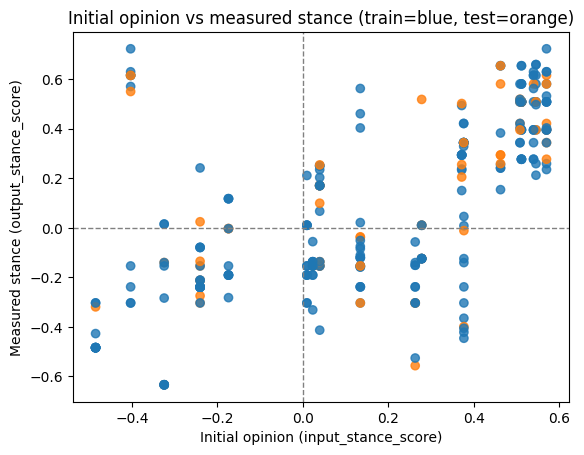

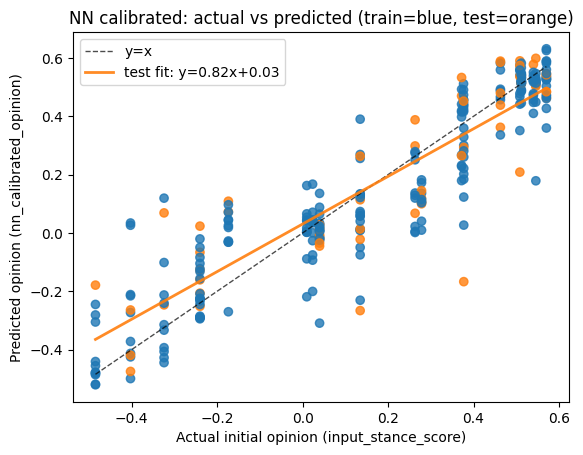

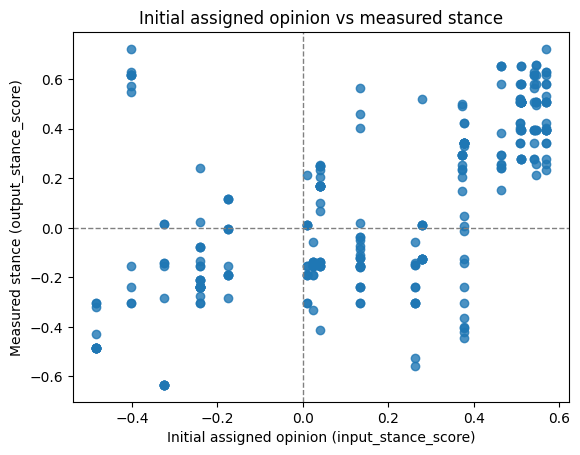

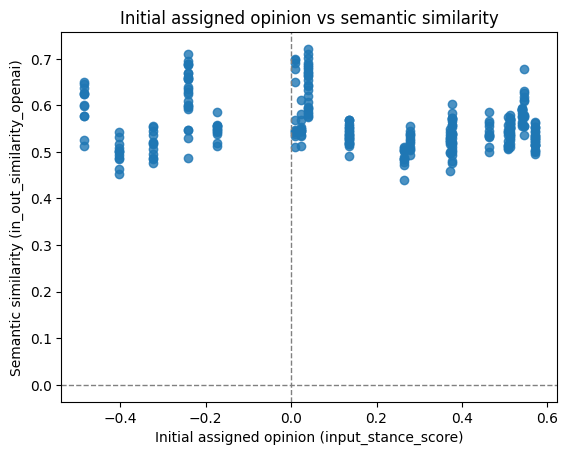

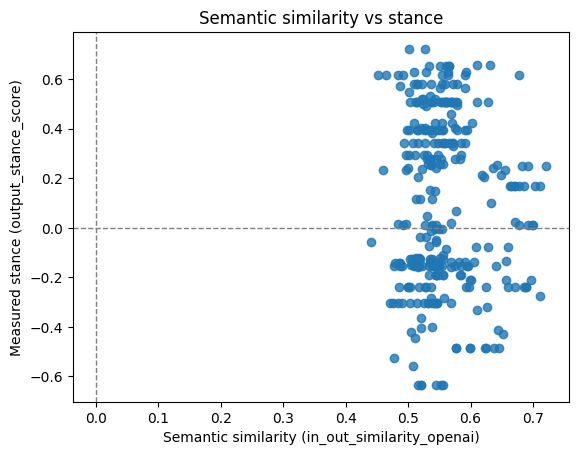

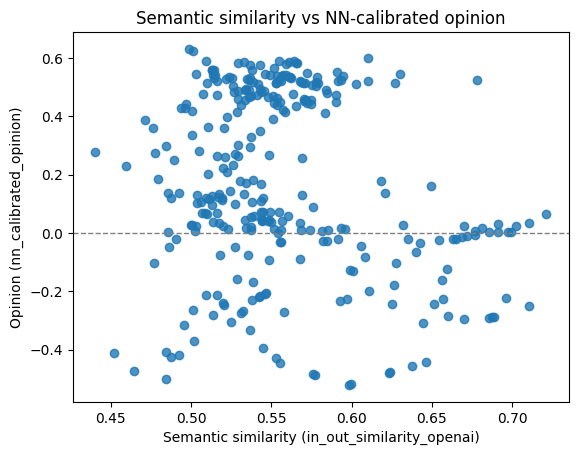


Baseline rows: 300

=== NN baseline (target=stance_weight) ===
  ep=   1  R2(train)=-0.090  R2(test)=-0.055  MSE(test)= 0.5226
  ep= 100  R2(train)= 0.790  R2(test)= 0.741  MSE(test)= 0.1282
  ep= 200  R2(train)= 0.811  R2(test)= 0.768  MSE(test)= 0.1149
  ep= 300  R2(train)= 0.824  R2(test)= 0.776  MSE(test)= 0.1111
  ep= 400  R2(train)= 0.834  R2(test)= 0.779  MSE(test)= 0.1095


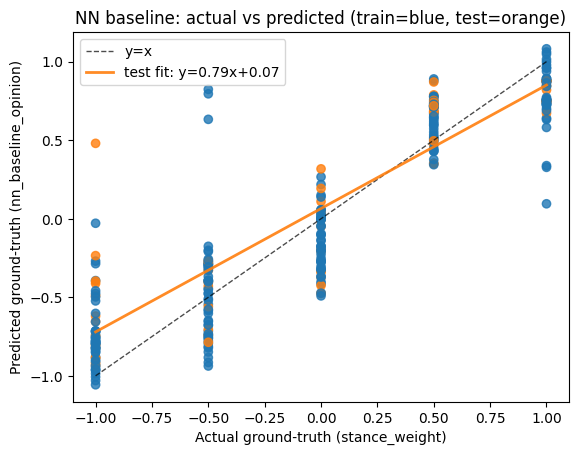

In [6]:
# --- Plots: initial vs outputs (similar to plots.ipynb) ---
colors = np.where(test_mask, "tab:orange", "tab:blue")

plt.figure()
plt.scatter(df["input_stance_score"], df["output_stance_score"], alpha=0.8, c=colors)
plt.xlabel("Initial opinion (input_stance_score)")
plt.ylabel("Measured stance (output_stance_score)")
plt.title("Initial opinion vs measured stance (train=blue, test=orange)")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

plt.figure()
plt.scatter(df["input_stance_score"], df["nn_calibrated_opinion"], alpha=0.8, c=colors)
plt.xlabel("Actual initial opinion (input_stance_score)")
plt.ylabel("Predicted opinion (nn_calibrated_opinion)")
plt.title("NN calibrated: actual vs predicted (train=blue, test=orange)")
xmin, xmax = float(df["input_stance_score"].min()), float(df["input_stance_score"].max())
plt.plot([xmin, xmax], [xmin, xmax], linestyle="--", linewidth=1, color="black", alpha=0.7, label="y=x")
test_df = df.iloc[idx_test]
if len(test_df) >= 2:
    m, c = np.polyfit(test_df["input_stance_score"].to_numpy(float), test_df["nn_calibrated_opinion"].to_numpy(float), deg=1)
    xs = np.array([xmin, xmax], dtype=float)
    plt.plot(xs, m * xs + c, linewidth=2, color="tab:orange", alpha=0.9, label=f"test fit: y={m:.2f}x+{c:.2f}")
plt.legend()
plt.show()

# Requested diagnostics:
# (1) Initial assigned opinion vs measured stance
plt.figure()
plt.scatter(df["input_stance_score"], df["output_stance_score"], alpha=0.8)
plt.xlabel("Initial assigned opinion (input_stance_score)")
plt.ylabel("Measured stance (output_stance_score)")
plt.title("Initial assigned opinion vs measured stance")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

# (2) Initial assigned opinion vs semantic similarity
plt.figure()
plt.scatter(df["input_stance_score"], df[semantic_col], alpha=0.8)
plt.xlabel("Initial assigned opinion (input_stance_score)")
plt.ylabel(f"Semantic similarity ({semantic_col})")
plt.title("Initial assigned opinion vs semantic similarity")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

# (3) Semantic similarity vs stance
plt.figure()
plt.scatter(df[semantic_col], df["output_stance_score"], alpha=0.8)
plt.xlabel(f"Semantic similarity ({semantic_col})")
plt.ylabel("Measured stance (output_stance_score)")
plt.title("Semantic similarity vs stance")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

# "Regenerate Section 5" style plot: opinion on vertical (using NN-calibrated opinion)
plt.figure()
plt.scatter(df[semantic_col], df["nn_calibrated_opinion"], alpha=0.8)
plt.xlabel(f"Semantic similarity ({semantic_col})")
plt.ylabel("Opinion (nn_calibrated_opinion)")
plt.title("Semantic similarity vs NN-calibrated opinion")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

# Optional: baseline target (ground-truth stance_weight) if available
baseline_available = ("stance_weight" in df.columns) and (not df["stance_weight"].isna().all())
if baseline_available:
    dfb = df.dropna(subset=["stance_weight"]).copy()
    print("\nBaseline rows:", len(dfb))
    idxb = np.arange(len(dfb))
    idxb_train, idxb_test = train_test_split(idxb, test_size=0.2, random_state=0)
    yb = dfb["stance_weight"].to_numpy(dtype=float)
    cols = feature_sets.get("sim_plus_stance", [semantic_col, "output_stance_score"])
    Xb_raw = dfb[cols].to_numpy(dtype=float)
    Xb_std, _, _ = _standardize(Xb_raw[idxb_train], Xb_raw)
    # reuse training, but temporarily swap global idx_train/idx_test used inside train_stancenet
    _old_train, _old_test = idx_train.copy(), idx_test.copy()
    idx_train, idx_test = idxb_train, idxb_test
    try:
        print("\n=== NN baseline (target=stance_weight) ===")
        _, yb_pred = train_stancenet(Xb_std, yb, epochs=400, lr=3e-3)
    finally:
        idx_train, idx_test = _old_train, _old_test
    dfb["nn_baseline_opinion"] = yb_pred

    plt.figure()
    colors_b = np.where(np.isin(np.arange(len(dfb)), idxb_test), "tab:orange", "tab:blue")
    plt.scatter(dfb["stance_weight"], dfb["nn_baseline_opinion"], alpha=0.8, c=colors_b)
    plt.xlabel("Actual ground-truth (stance_weight)")
    plt.ylabel("Predicted ground-truth (nn_baseline_opinion)")
    plt.title("NN baseline: actual vs predicted (train=blue, test=orange)")
    xmin, xmax = float(dfb["stance_weight"].min()), float(dfb["stance_weight"].max())
    plt.plot([xmin, xmax], [xmin, xmax], linestyle="--", linewidth=1, color="black", alpha=0.7, label="y=x")
    test_b = dfb.iloc[idxb_test]
    if len(test_b) >= 2:
        m, c = np.polyfit(test_b["stance_weight"].to_numpy(float), test_b["nn_baseline_opinion"].to_numpy(float), deg=1)
        xs = np.array([xmin, xmax], dtype=float)
        plt.plot(xs, m * xs + c, linewidth=2, color="tab:orange", alpha=0.9, label=f"test fit: y={m:.2f}x+{c:.2f}")
    plt.legend()
    plt.show()
else:
    print("\nNo stance_weight available; skipping NN baseline target.")